In [11]:
import os
import requests as req
import seaborn as sns
import hypertools as hyp
import pandas as pd
import numpy as np
from helpers import download_file_from_google_drive as dl
import html2text
import markdown
from bs4 import BeautifulSoup
from scipy.spatial.distance import cdist, pdist, squareform
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords as sw

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, Birch, FeatureAgglomeration, SpectralClustering, SpectralCoclustering, SpectralBiclustering, DBSCAN, AffinityPropagation, MeanShift
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA, FastICA, IncrementalPCA, KernelPCA, FactorAnalysis, TruncatedSVD, SparsePCA, MiniBatchSparsePCA, DictionaryLearning, MiniBatchDictionaryLearning
from sklearn.manifold import TSNE, MDS, SpectralEmbedding, LocallyLinearEmbedding, Isomap
from umap import UMAP
from flair.embeddings import WordEmbeddings, CharacterEmbeddings, StackedEmbeddings, FlairEmbeddings, BertEmbeddings, ELMoEmbeddings, DocumentPoolEmbeddings
from flair.data import Sentence

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeremy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub

tf.disable_v2_behavior()
tf.disable_eager_execution()

In [2]:
fileid = '1hCCn31z4HM4IzQi59DP-vvUpYKhlvo2S'
datadir = '../data'
fname = os.path.join(datadir, 'data.csv')

if not os.path.exists(datadir):
    os.makedirs(datadir)
    
if not os.path.exists(fname):
    print('Fetching file from the interwebz!')
    dl(fileid, fname)
else:
    print('Data found!')

Data found!


In [3]:
data = pd.read_csv(fname)

In [4]:
data.head()

id                       title  \
0   1  10 Things I Hate About You   
1   2                          12   
2   3              12 and Holding   
3   4                  12 Monkeys   
4   5            12 Years a Slave   

                                                 url  \
0  http://www.imsdb.com/scripts/10-Things-I-Hate-...   
1               http://www.imsdb.com/scripts/12.html   
2   http://www.imsdb.com/scripts/12-and-Holding.html   
3       http://www.imsdb.com/scripts/12-Monkeys.html   
4  http://www.imsdb.com/scripts/12-Years-a-Slave....   

                                             writers                 genres  \
0  Karen McCullah Lutz;Kirsten Smith;William Shak...         Comedy;Romance   
1                                   Lawrence Bridges                 Comedy   
2                                   Anthony Cipriano                  Drama   
3                        David Peoples;Janet Peoples  Drama;Sci-Fi;Thriller   
4                                        John Ridley                  Drama   

                                              script  
0  \n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...  
1                            \n\n  \n  12 - Script\n  
2             \n          \n          \n         ...  
3  \n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...  
4  \r\n\r\n\r\n                             12 YE...

In [5]:
def wipe_formatting(script, rehtml=False):
    try:
        parser = html2text.HTML2Text()
        parser.wrap_links = True
        parser.skip_internal_links = True
        parser.inline_links = True
        parser.ignore_anchors = True
        parser.ignore_images = True
        parser.ignore_emphasis = True
        parser.ignore_links = True
        text = parser.handle(script)
        text = text.strip(' \t\n\r')
        if rehtml:
            text = text.replace('\n', '<br/>')
            text = text.replace('\\', '')
        md = markdown.markdown(text)
        soup=BeautifulSoup(md,'html5lib')
        soup=soup.get_text()
        soup = soup.replace('\n', ' ')
        return soup
    except AttributeError:
        return ''

def sliding_window(script, n=100, delim=' '):
    words = wipe_formatting(script).split(delim)
    x = []
    for i in np.arange(len(words)-n):
        x.append(delim.join(words[i:(i+n)]))
    return x
    

In [6]:
data['formatted_script'] = data['script'].apply(wipe_formatting)

In [7]:
data.head()

id                       title  \
0   1  10 Things I Hate About You   
1   2                          12   
2   3              12 and Holding   
3   4                  12 Monkeys   
4   5            12 Years a Slave   

                                                 url  \
0  http://www.imsdb.com/scripts/10-Things-I-Hate-...   
1               http://www.imsdb.com/scripts/12.html   
2   http://www.imsdb.com/scripts/12-and-Holding.html   
3       http://www.imsdb.com/scripts/12-Monkeys.html   
4  http://www.imsdb.com/scripts/12-Years-a-Slave....   

                                             writers                 genres  \
0  Karen McCullah Lutz;Kirsten Smith;William Shak...         Comedy;Romance   
1                                   Lawrence Bridges                 Comedy   
2                                   Anthony Cipriano                  Drama   
3                        David Peoples;Janet Peoples  Drama;Sci-Fi;Thriller   
4                                        John Ridley                  Drama   

                                              script  \
0  \n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...   
1                            \n\n  \n  12 - Script\n   
2             \n          \n          \n         ...   
3  \n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...   
4  \r\n\r\n\r\n                             12 YE...   

                                    formatted_script  
0  Ten Things I Hate About You - by Karen McCulla...  
1                                        12 - Script  
2  12 AND HOLDING Written by Anthony S Cipriano 0...  
3  Twelve Monkeys TWELVE MONKEYS An original scre...  
4  12 YEARS A SLAVE Written by John Ridley CARD: ...

0       Ten Things I Hate About You - by Karen McCulla...
1                                             12 - Script
2       12 AND HOLDING Written by Anthony S Cipriano 0...
3       Twelve Monkeys TWELVE MONKEYS An original scre...
4       12 YEARS A SLAVE Written by John Ridley CARD: ...
5       127 HOURS Written by Simon Beaufoy & Danny Boy...
6       1492: CONQUEST OF PARADISE 1492: CONQUEST OF P...
7       15 Minutes FADE IN on the words CZECH AIRLINE....
8       17 AGAIN Written by Jason Filardi October 2007...
9       187 by Scott Yagemann REVISED SHOOTING DRAFT N...
10      2001: A SPACE ODYSSEY Screenplay by Stanley Ku...
11      2012 Written by Roland Emmerich & Harald Klose...
12      THE 25th HOUR by David Benioff 4/30/01 INDUSTR...
13      30 MINUTES OR LESS Written by Michael Dilibert...
14      42 Written by Brian Helgeland White - March 14...
15      44 INCH CHEST Written by Louis Mellis & David ...
16                     "48 HRS." -- Unknown draft/writers
17      50/50 

In [9]:
x = sliding_window(data.iloc[0]['script'], delim='.', n=25)

In [10]:
x[0]

'Ten Things I Hate About You - by Karen McCullah Lutz & Kirsten Smith TEN THINGS I HATE ABOUT YOU written by Karen McCullah Lutz & Kirsten Smith based on \'Taming of the Shrew" by William Shakespeare Revision November 12, 1997 PADUA HIGH SCHOOL - DAY Welcome to Padua High School,, your typical urban- suburban high school in Portland, Oregon. Smarties, Skids, Preppies, Granolas. Loners, Lovers, the In and the Out Crowd rub sleep out of their eyes and head for the main building. PADUA HIGH PARKING LOT - DAY KAT STRATFORD, eighteen, pretty -- but trying hard not to be -- in a baggy granny dress and glasses, balances a cup of coffee and a backpack as she climbs out of her battered, baby blue \'75 Dodge Dart. A stray SKATEBOARD clips her, causing her to stumble and spill her coffee, as well as the contents of her backpack. The young RIDER dashes over to help, trembling when he sees who his board has hit. RIDER Hey -- sorry. Cowering in fear, he attempts to scoop up her scattered belongings.

In [11]:
x[1]

" Smarties, Skids, Preppies, Granolas. Loners, Lovers, the In and the Out Crowd rub sleep out of their eyes and head for the main building. PADUA HIGH PARKING LOT - DAY KAT STRATFORD, eighteen, pretty -- but trying hard not to be -- in a baggy granny dress and glasses, balances a cup of coffee and a backpack as she climbs out of her battered, baby blue '75 Dodge Dart. A stray SKATEBOARD clips her, causing her to stumble and spill her coffee, as well as the contents of her backpack. The young RIDER dashes over to help, trembling when he sees who his board has hit. RIDER Hey -- sorry. Cowering in fear, he attempts to scoop up her scattered belongings. KAT Leave it He persists. KAT (continuing) I said, leave it! She grabs his skateboard and uses it to SHOVE him against a car, skateboard tip to his throat. He whimpers pitifully and she lets him go. A path clears for her as she marches through a pack of fearful students and SLAMS open the door, entering school. INT. GIRLS' ROOM - DAY BIANCA

In [12]:
y = hyp.tools.format_data(x, corpus=x, semantic={'model':'LatentDirichletAllocation', 'params':{'n_components' : 100}}, vectorizer={'model':'CountVectorizer', 'params':{'stop_words':sw.words('English')}})

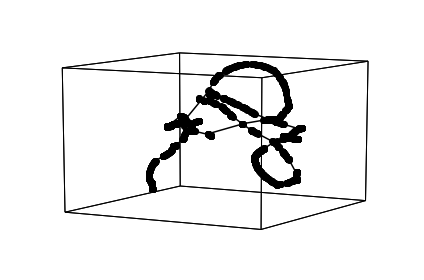

In [13]:
hyp.plot(y, 'ko-', reduce='UMAP', ndims=3)

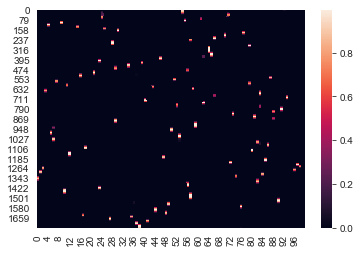

In [14]:
sns.heatmap(y[0])

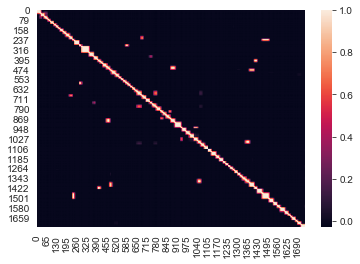

In [15]:
sns.heatmap(1 - squareform(pdist(y[0], 'correlation')))